In [1]:
import torch 
import torchvision
from torch import nn, optim
from torchvision import transforms
from torch.nn import functional as F

import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import List

In [2]:
class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        ## C,1,1 shape for broadcasting
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [3]:
class customloss(nn.Module):
    
    def __init__(self):
        super(customloss, self).__init__()
        self.style_layer = style_layer
        self.unfold = nn.Unfold(3)
    
    def styleloss(self, s, i):
        
        s_patch = self.patchify(s)
        i_patch = self.patchify(i)
        
        knn = self.find_nn(s_patch, i_patch)
        
        # only style and output compared, no semantic map
        return F.mse_loss(i_patch[:(i.size(1)-3)*3*3], s_patch[:(s.size(1)-3)*3*3,knn],reduction='sum')
    
    def total_variation_loss(self, x):
        # only output computed, no semantic map
        # tv is calculated loss to right and down
        down_loss = F.mse_loss(x[:,(x.shape[1]-3),1:,:-1],x[:,(x.shape[1]-3),:-1,:-1],reduction='sum')
        right_loss = F.mse_loss(x[:,(x.shape[1]-3),:-1,1:],x[:,(x.shape[1]-3),:-1,:-1],reduction='sum')
        return right_loss + down_loss
    
    def patchify(self, x):
        return self.unfold(x).squeeze()
    
    def find_nn(self, s, i):
        
        i_norm = i/i.norm(p=2,dim=0,keepdim=True) # C*3*3, (H-2)*(W-2) => pixel_num, patch_num
        s_norm = s/s.norm(p=2,dim=0,keepdim=True) # patch norm

        similarity_matrix = i_norm.t() @ s_norm # patch, patch       
        nearest_neighbours = similarity_matrix.argmax(dim=1) # for input patch, which style patch is the closet
        
        return nearest_neighbours
        
    def forward(self, smap: List[torch.Tensor], imap: List[torch.Tensor]):
        content_loss = 0
        style_loss = 0
        tv_loss = 0
        
        for s,i in zip(smap,imap): style_loss += self.styleloss(s, i)
#         for i in imap: tv_loss += self.total_variation_loss(i)
                
        return content_loss, style_loss, tv_loss

In [4]:
def muliscale_calc(h:int,w:int) -> List[int]:
    max_h, max_w = int(h*max_scale), int(w*max_scale)
    hw_list = [[max_h,max_w]]
    while 1:
        new_h, new_w = max_h // 2, max_w // 2
        if new_h >= 64 or new_w >= 64:
            hw_list.append([new_h, new_w])
            max_h, max_w = new_h, new_w
        else:
            break
    return hw_list

In [5]:
def run_synthesize(model, style_img, style_map, input_map):
    """Run the style transfer."""
            
    _, _, h, w = style_img.shape
    hw_list = muliscale_calc(763,770)    
    hw_list.reverse()
        
    output_img = torch.rand(1,3,hw_list[0][0],hw_list[0][1]).to(device)    
    
    # calculate multiscale
    for i, (h,w) in enumerate(hw_list):
        print(f'phases {i+1} begins')

        _style_img = transforms.Resize((h,w))(style_img)
        _style_map = transforms.Resize((h,w))(style_map)
        _input_map = transforms.Resize((h,w))(input_map)
        
        optimizer = optim.LBFGS([output_img.requires_grad_()])
    
        for i in range(num_steps+1):

            output_img.data.clip_(0,1)
            
            optimizer.zero_grad()
            
            with torch.no_grad():
                _, s_map = model(_style_img, _style_map,mode='style')
            _, i_map = model(output_img, _input_map,mode='map')
            
            content_score, style_score, tv_score = criterion(s_map, i_map)

            loss = content_weight * content_score + style_weight * style_score + smoothness * tv_score
            loss.backward()

            loss_val = optimizer.step(lambda: loss)
            

            if (i % 50) == 0: print(f'{i : < 6} {style_score.item()}')
        
        output_img = F.interpolate(output_img,scale_factor=2).detach()
    
    output_img.data.clip_(0,1)

    return output_img

# setting

In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [7]:
device = 'cuda:0'

In [8]:
style_layer = ['3_1','4_1']
content_layer = ['4_2']

In [9]:
content_weight = 10
style_weight = 25
smoothness = 1
user_control_weight = 50 #50 #5e4
num_steps = 300
max_scale = 0.5

In [10]:
# semantic_weight = math.sqrt(9/semantic_weight_ori)

# model

In [11]:
cnn = torchvision.models.vgg19(pretrained=True).features.to(device).eval()

In [12]:
class Aux_Network(nn.Module):
    
    def __init__(self):
        super(Aux_Network, self).__init__()
        self.normalization = Normalization(IMAGENET_MEAN,IMAGENET_STD)
        self.feature_extractor = cnn
#         self.neighber_conv = [nn.Conv2d(i+3,3,3,bias=False).to(device) for i in [256,512]]
        
    def forward(self, img, mapping,mode:str):
        block_num, conv_num = 0, 0
        conv_list = []
        aux_list = []
        
        img = self.normalization(img)
        
        for l in self.feature_extractor:
            img = l(img)
            if isinstance(l, nn.ReLU):
                conv_num += 1
                layer_name = f'{block_num+1}_{conv_num}'
                if layer_name in style_layer:
                    channel_num = img.shape[1]
                    pool_map = F.avg_pool2d(mapping,2**block_num)
                    aux_list.append(torch.cat([img, user_control_weight*pool_map],dim=1)) #*channel_num
#                 if layer_name in content_layer:
#                     if mode == 'content': conv_list.append(img)
            elif isinstance(l, nn.MaxPool2d):
                block_num += 1
                conv_num = 0
        
#         for a,c in zip(aux_list,self.neighber_conv):
#             a = c(a)
        
        return conv_list, aux_list

In [13]:
model = Aux_Network()

In [14]:
# test_case = Aux_Network()(torch.rand(1,3,224,224),torch.rand(1,3,224,224),mode='style')

In [15]:
# for i in test_case[1]: print(i.shape)

In [16]:
criterion = customloss()

In [17]:
# criterion(test_case[1],test_case[1])

In [18]:
# torch.onnx.export(model,(torch.rand(1,3,224,224).cuda(),torch.rand(1,3,224,224).cuda()),'a.onnx')

# start transfer

In [19]:
ToTensor = transforms.Compose([
  transforms.ToTensor()  
])

In [20]:
style_img = ToTensor(Image.open('forest.jpg')).unsqueeze(0).to(device)
style_map = ToTensor(Image.open('map.png')).unsqueeze(0).to(device)
input_map = ToTensor(Image.open('output.jpg')).unsqueeze(0).to(device)

In [21]:
output = run_synthesize(model, style_img, style_map, input_map)

phases 1 begins


C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 0     53752304.0
 50    13348608.0
 100   12195582.0
 150   11716350.0
 200   11500552.0
 250   11391242.0
 300   11254606.0
phases 2 begins
 0     189487360.0
 50    27268766.0
 100   22653382.0
 150   20924910.0
 200   20142528.0
 250   19419580.0
 300   18734270.0
phases 3 begins
 0     580278016.0
 50    71678040.0
 100   56252716.0
 150   50850460.0
 200   48588316.0
 250   46931224.0
 300   46004108.0


# visualize

In [22]:
def tensor_to_np(tensor):
    return tensor.permute(0,2,3,1).squeeze(0).detach().cpu().numpy() 

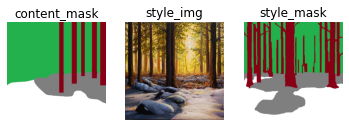

In [23]:
plt.subplot(1,3,1)
plt.title('content_mask')
plt.axis('off')
plt.imshow(tensor_to_np(input_map))
plt.subplot(1,3,2)
plt.title('style_img')
plt.axis('off')
plt.imshow(tensor_to_np(style_img))
plt.subplot(1,3,3)
plt.title('style_mask')
plt.axis('off')
plt.imshow(tensor_to_np(style_map))

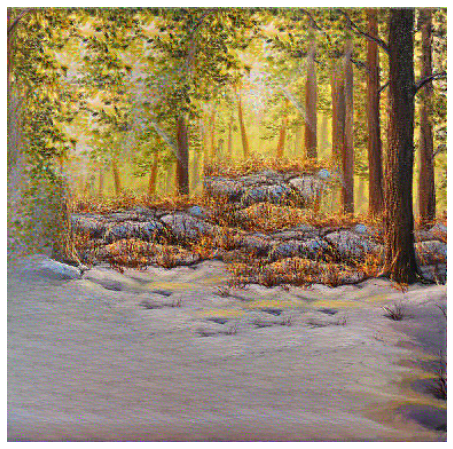

In [27]:
output_post = output.permute(0,2,3,1).squeeze(0).detach().cpu().numpy()

plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(output_post)

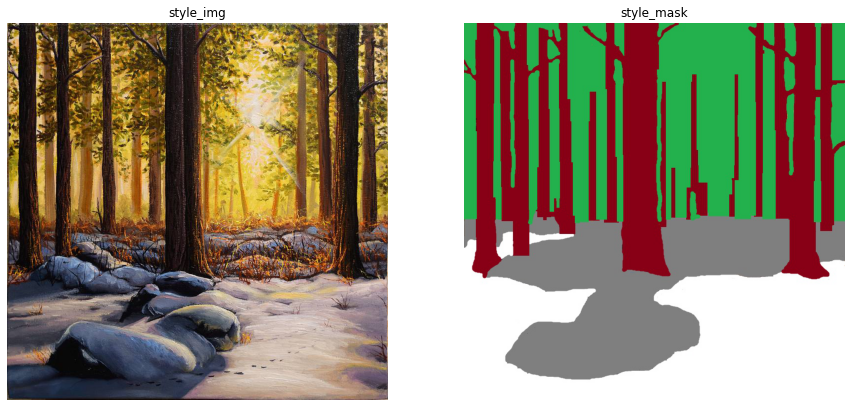

In [25]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('style_img')
plt.axis('off')
plt.imshow(tensor_to_np(style_img))
plt.subplot(1,2,2)
plt.title('style_mask')
plt.axis('off')
plt.imshow(tensor_to_np(style_map))

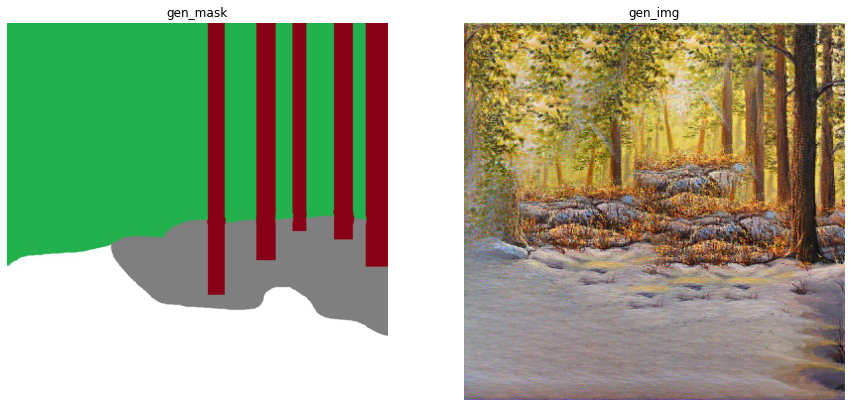

In [26]:
fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('gen_mask')
plt.axis('off')
plt.imshow(tensor_to_np(input_map))
plt.subplot(1,2,2)
plt.title('gen_img')
plt.axis('off')
plt.imshow(output_post)
# fig.savefig('doc2.jpg')